In [1]:
#run step1_gatherData.py

In [1]:
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
from scipy.stats import norm
%matplotlib inline

### 1. Load in the summarized subject data

In [32]:
df = pd.read_pickle('gpData_v2.pkl')
NrSbj = len(df.sbjId.unique())
print('A total of ' + str(NrSbj) + ' subjects')

A total of 43 subjects


#### 1a. Exclude subjects with low task-switching accuracy (<55%) and low Correct Rejection Rate (<55%)

In [34]:
#%% do a fist pass to exclude subjects with low cued task accuracy
goodSbj=[]
excludeSbj=[]
for S in np.unique(df.sbjId):
    D = df.loc[df.sbjId==S]    
    if (D[D.phase=='TaskSw'].sbjACC.mean()*100 > 55) & (D.loc[D.memCond=='new'].sbjACC.mean()*100 > 55):
        goodSbj.append(S)
    else:
        excludeSbj.append(S)
for S in excludeSbj:
    df.drop(df[df.sbjId==S].index, axis=0, inplace=True)
validSCNT = len(np.unique(df.sbjId))
print('After excluding subjects with poor performance: A total of ' + str(validSCNT) + ' subjects')

After excluding subjects with poor performance: A total of 26 subjects


### 2. Look at Task-switching data:

Overall accuracy for the task-switching control task was 76.17%
Overall RT (correct trials) for the task-switching control task was 718.94ms


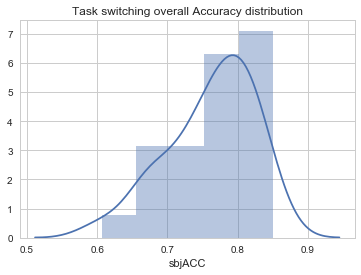

In [5]:
df_tskSw = df.loc[df.phase=='TaskSw',:]
sbj_tsACC = df_tskSw.groupby('sbjId').sbjACC.mean()
#print(sbj_tsACC)  # might need to exclude low accuracy subjects later on - lower than 70% or 65%
sns.distplot(sbj_tsACC)
plt.title('Task switching overall Accuracy distribution')
TS_meanACC = df_tskSw.groupby('sbjId').sbjACC.mean().mean()*100
TS_meanRT = df_tskSw.loc[df_tskSw.sbjACC==1,:].groupby('sbjId').sbjRT.mean().mean()
print('Overall accuracy for the task-switching control task was ' + '{:.2f}'.format(TS_meanACC) + '%')
print('Overall RT (correct trials) for the task-switching control task was ' + '{:.2f}'.format(TS_meanRT) + 'ms')

#### Look at Task-switching data over 'repetition' (v2 has 2 repetitions of task-switching task)

------Group mean ACC (by Repetition)--------
Repetition
Rep1    71.754808
Rep2    80.576923
Name: sbjACC, dtype: float64


[(0.6, 0.9)]

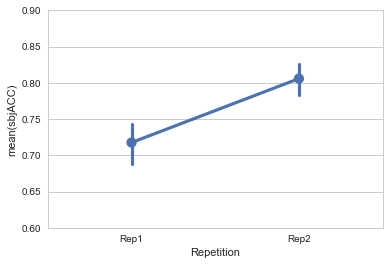

In [6]:
sbj_tsACC_byRep  = df_tskSw.groupby(['sbjId','Repetition']).sbjACC.mean().reset_index()  
gpResult_ts_acc_byRep  = sbj_tsACC_byRep.groupby(['Repetition']).sbjACC.mean()*100
print('------Group mean ACC (by Repetition)--------')
print(gpResult_ts_acc_byRep)
g = sns.pointplot(x="Repetition", y="sbjACC", data = sbj_tsACC_byRep)
g.set(ylim=(.6, .9))

#### 2a. Task-switching ACC as a function of 2 (respComp: RC, RIC ) x 2 (Trial Type: switch/repeat) 

------Group mean ACC--------
respComp  trialType
RC        switch       82.932692
          repeat       92.115385
RIC       switch       53.990385
          repeat       75.625000
Name: sbjACC, dtype: float64


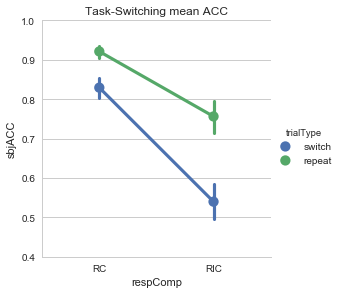

In [7]:
condM_ts_acc = df_tskSw.groupby(['sbjId','respComp','trialType']).sbjACC.mean().reset_index()  
# a dataframe of subject x condition 
gpResult_ts_acc  = condM_ts_acc.groupby(['respComp','trialType']).sbjACC.mean()*100
print('------Group mean ACC--------')
print(gpResult_ts_acc)
g = sns.factorplot(x='respComp',y='sbjACC', data=condM_ts_acc , hue='trialType')
plt.title("Task-Switching mean ACC")
g.set(ylim=(.4, 1))

#### 2b. Task-switching RT (correct trials) as a function of 2 (respComp: RC, RIC ) x 2 (Trial Type: switch/repeat) 

------Group mean RT (correct trials only)--------
respComp  trialType
RC        switch       725.329653
          repeat       679.998026
RIC       switch       783.406517
          repeat       715.559558
Name: sbjRT, dtype: float64


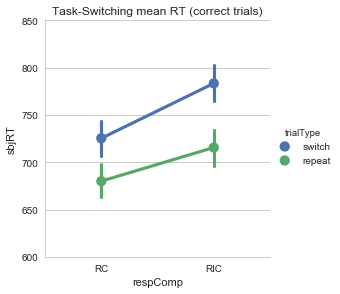

In [8]:
condM_ts_rt = df_tskSw.loc[df_tskSw.sbjACC==1,:].groupby(['sbjId','respComp','trialType']).sbjRT.mean().reset_index()
# a dataframe of subject x condition 
gpResult_ts_rt = condM_ts_rt.groupby(['respComp','trialType']).sbjRT.mean()
print('------Group mean RT (correct trials only)--------')
print(gpResult_ts_rt)
g = sns.factorplot(x='respComp',y='sbjRT', data=condM_ts_rt , hue='trialType')
g.set(ylim=(600, 850))
plt.title("Task-Switching mean RT (correct trials)")

#### 2c. Task-switching RT (correct trials) as a function of 2 (task: animacy, size) x 2 (respComp: RC, RIC ) x 2 (Trial Type: switch/repeat)

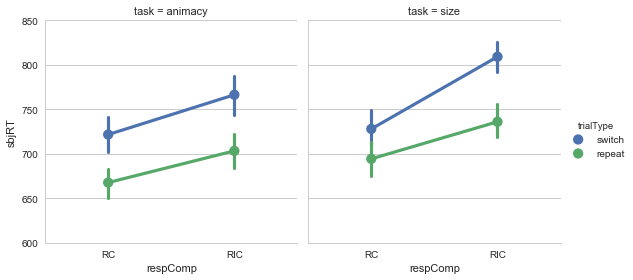

In [9]:
condM_ts_rt_byTask = df_tskSw.loc[df_tskSw.sbjACC==1,:].groupby(['sbjId','task','respComp','trialType']).sbjRT.mean().reset_index()
g = sns.factorplot(x='respComp',y='sbjRT', hue="trialType",col="task", data=condM_ts_rt_byTask )
g.set(ylim=(600, 850))

### 3. Look at Subsequent Memory Data

In [10]:
df_mem = df.loc[df.phase=='Mem',:]
mem_meanACC = df_mem.groupby('sbjId').sbjACC.mean().mean()*100
mem_meanRT = df_mem.groupby('sbjId').sbjRT.mean().mean()
print('Overall accuracy for the subsequent memory task (all items: old and new) was ' + '{:.2f}'.format(mem_meanACC) + '%')
print('Overall RT (all trials) for the subsequent memory task was ' + '{:.2f}'.format(mem_meanRT) + 'ms')

Overall accuracy for the subsequent memory task (all items: old and new) was 74.17%
Overall RT (all trials) for the subsequent memory task was 929.98ms


#### 3a. Overall correct Rejection (CR) Rate (new item and rated as 'new')

False Alarm Rate was 18.32%


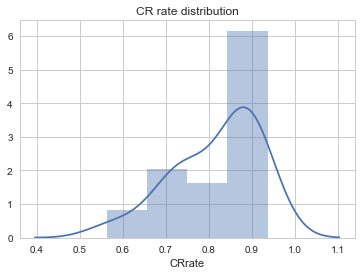

In [11]:
condM_mem_CRrate = df_mem.loc[df_mem.memCond=='new',:].groupby('sbjId').sbjACC.mean().reset_index()
condM_mem_CRrate.rename(columns={'sbjACC': 'CRrate'}, inplace=True)
# a table of subject x condition 
#print(sbj_CRrate)  # if a subject's correct rejection rate is too low, might need to exclude this subject later on
sns.distplot(condM_mem_CRrate.CRrate)
plt.title('CR rate distribution')
gpResult_CRrate = condM_mem_CRrate.CRrate.mean()*100
print('False Alarm Rate was ' + '{:.2f}'.format(100-gpResult_CRrate) + '%')

#### 3b. Correct Rejection (CR) Rate (new item and rated as 'new') and Hit Rate (old item as 'old') broken down by stimulus category

oldNew  stimCat
New     Liv-Lg     79.615385
        Liv-Sm     74.807692
        NLiv-Lg    83.461538
        NLiv-Sm    88.846154
Old     Liv-Lg     69.134615
        Liv-Sm     72.115385
        NLiv-Lg    66.923077
        NLiv-Sm    73.461538
Name: sbjACC, dtype: float64


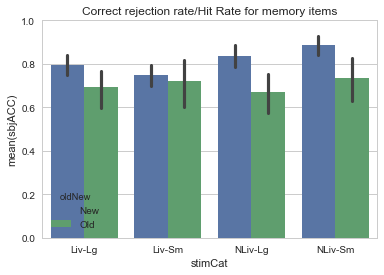

In [12]:
memACC_byCat = df_mem.groupby(['sbjId','oldNew','stimCat']).sbjACC.mean().reset_index()
# 2(Old, New) x 4(living-large, living-small, nonliving-large, nonliving-small)
gpResult_memACC_byCat = memACC_byCat.groupby(['oldNew','stimCat']).sbjACC.mean()*100
print(gpResult_memACC_byCat)
g = sns.barplot(x='stimCat',y='sbjACC',hue = 'oldNew', data = memACC_byCat)
g.set(ylim=(0, 1))
plt.title("Correct rejection rate/Hit Rate for memory items")

#### 3c. Hit rate (old item and rated as 'old', all correct trials during T1) as a function of  2 (respComp: RC, RIC ) x 2 (Trial Type: switch/repeat) 

---------- Group mean Hit Rate (T1 correct items only) -----------
respComp  trialType
RC        switch       70.105286
          repeat       71.206664
RIC       switch       66.674814
          repeat       70.216125
Name: Hits, dtype: float64


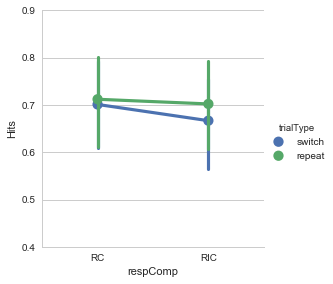

In [13]:
# Look at only images that were correct during T1 (Task-switching)
df_old = df_mem.loc[(df_mem.memCond!='new') & (df_mem.task1ACC==1)]
condM_mem_hits = df_old.groupby(['sbjId','respComp','trialType']).sbjACC.mean().reset_index()
condM_mem_hits.rename(columns={'sbjACC': 'Hits'}, inplace=True)
# a table of subject x condition 
gpResult_hits= condM_mem_hits.groupby(['respComp','trialType']).Hits.mean()*100
print('---------- Group mean Hit Rate (T1 correct items only) -----------')
print(gpResult_hits)
g = sns.factorplot(x='respComp',y='Hits', hue="trialType",data = condM_mem_hits)
g.set(ylim=(0.4, 0.9))

In [14]:
# Testing interaction on T1 correct imgages
a = np.array(condM_mem_hits.loc[(condM_mem_hits.respComp=='RC') & (condM_mem_hits.trialType=='switch'),'Hits'])
b = np.array(condM_mem_hits.loc[(condM_mem_hits.respComp=='RC') & (condM_mem_hits.trialType=='repeat'),'Hits'])
c = np.array(condM_mem_hits.loc[(condM_mem_hits.respComp=='RIC') & (condM_mem_hits.trialType=='switch'),'Hits'])
d = np.array(condM_mem_hits.loc[(condM_mem_hits.respComp=='RIC') & (condM_mem_hits.trialType=='repeat'),'Hits'])
simple_inX_test = stats.ttest_rel(a-b,c-d)
print(simple_inX_test.pvalue)

0.328898475673


#### 3d. Hit rate (old item and rated as 'old', all correct trials during T1) as a function of  2 (task: Animacy, Size) x 2 (respComp: RC, RIC ) x 2 (Trial Type: switch/repeat) 

task     respComp  trialType
animacy  RC        switch       67.055177
                   repeat       71.110785
         RIC       switch       62.713302
                   repeat       67.411463
size     RC        switch       73.448584
                   repeat       71.647412
         RIC       switch       71.035209
                   repeat       74.513736
Name: Hits, dtype: float64
Subsequent Memory Task mean ACC(Hit rate) as a function of task


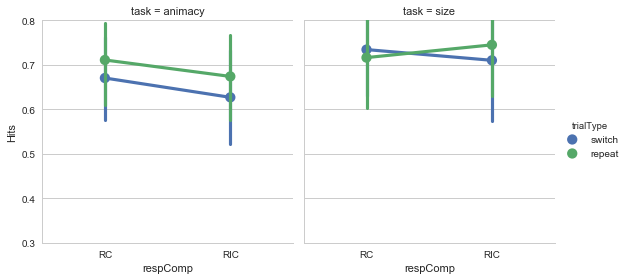

In [15]:
condM_mem_hits_byTask = df_old.groupby(['sbjId','task','respComp','trialType']).sbjACC.mean().reset_index()
condM_mem_hits_byTask.rename(columns={'sbjACC': 'Hits'}, inplace=True)
gpResult_hits_byTask = condM_mem_hits_byTask.groupby(['task','respComp','trialType']).Hits.mean()*100
print(gpResult_hits_byTask)
print('Subsequent Memory Task mean ACC(Hit rate) as a function of task')
g = sns.factorplot(x='respComp',y='Hits',col="task", hue="trialType",data = condM_mem_hits_byTask)
g.set(ylim=(0.3, 0.8))

In [18]:
# Testing interaction with Task = ANIMACY
a = np.array(condM_mem_hits_byTask.loc[(condM_mem_hits_byTask.task=='animacy') & (condM_mem_hits_byTask.respComp=='RC') & (condM_mem_hits_byTask.trialType=='switch'),'Hits'])
b = np.array(condM_mem_hits_byTask.loc[(condM_mem_hits_byTask.task=='animacy') & (condM_mem_hits_byTask.respComp=='RC') & (condM_mem_hits_byTask.trialType=='repeat'),'Hits'])
c = np.array(condM_mem_hits_byTask.loc[(condM_mem_hits_byTask.task=='animacy') & (condM_mem_hits_byTask.respComp=='RIC') & (condM_mem_hits_byTask.trialType=='switch'),'Hits'])
d = np.array(condM_mem_hits_byTask.loc[(condM_mem_hits_byTask.task=='animacy') & (condM_mem_hits_byTask.respComp=='RIC') & (condM_mem_hits_byTask.trialType=='repeat'),'Hits'])
simple_inX_test = stats.ttest_rel(a-b,c-d)
print(simple_inX_test.pvalue)

0.886387498886


#### 3d. Calculate false alarm rate by response compatibility 

In [19]:
condM_mem_byCat = df_old.groupby(['sbjId','respComp','trialType','stimCat']).sbjACC.mean().reset_index()
condM_mem_byCat.rename(columns={'sbjACC': 'Hits'}, inplace=True)
CRrate_byCat = df_mem.loc[df_mem.memCond=='new',:].groupby(['sbjId','stimCat']).sbjACC.mean().reset_index()
CRrate_byCat.rename(columns={'sbjACC': 'CRrate'}, inplace=True)
for r in range(0,len(condM_mem_byCat)-1,1):
    S     = condM_mem_byCat.loc[r,'sbjId']
    sCat  = condM_mem_byCat.loc[r,'stimCat']    
    condM_mem_byCat.loc[r,'CRrate']= float(CRrate_byCat.loc[(CRrate_byCat.stimCat==sCat) & (CRrate_byCat.sbjId==S),'CRrate'])

In [20]:
condM_mem_byCat.Hits.replace(1, 19.5/20, inplace=True)
condM_mem_byCat.CRrate.replace(1, 19.5/20, inplace=True)
condM_mem_byCat.Hits.replace(0, 0.5/20, inplace=True)
condM_mem_byCat.CRrate.replace(0, 0.5/20, inplace=True)
condM_mem_byCat['zHit']=stats.norm.ppf(condM_mem_byCat.Hits)
condM_mem_byCat['zFA'] =stats.norm.ppf(1-condM_mem_byCat.CRrate)
condM_mem_byCat['dprime'] = condM_mem_byCat['zHit'] - condM_mem_byCat['zFA']

C:\Users\yc180\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1901: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
C:\Users\yc180\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1901: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


#### 3e. d prime as a function of  2 (respComp: RC, RIC ) x 2 (Trial Type: switch/repeat) 

------Memory d prime--------
respComp  trialType
RC        switch       1.686253
          repeat       1.708752
RIC       switch       1.575980
          repeat       1.642162
Name: dprime, dtype: float64


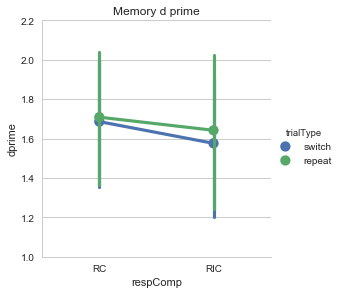

In [24]:
condM_dprime = condM_mem_byCat.groupby(['sbjId','respComp','trialType']).dprime.mean().reset_index()
# a table of subject x condition 
gpResult_mem_dprime = condM_dprime.groupby(['respComp','trialType']).dprime.mean()
g = sns.factorplot(x='respComp',y = 'dprime', hue='trialType', data=condM_dprime)
g.set(ylim=(1,2.2))
plt.title('Memory d prime')
print('------Memory d prime--------')
print(gpResult_mem_dprime)

In [25]:
# Testing dprime interaction on T1 correct imgages
a = np.array(condM_dprime.loc[(condM_dprime.respComp=='RC')  & (condM_dprime.trialType=='switch'),'dprime'])
b = np.array(condM_dprime.loc[(condM_dprime.respComp=='RC')  & (condM_dprime.trialType=='repeat'),'dprime'])
c = np.array(condM_dprime.loc[(condM_dprime.respComp=='RIC') & (condM_dprime.trialType=='switch'),'dprime'])
d = np.array(condM_dprime.loc[(condM_dprime.respComp=='RIC') & (condM_dprime.trialType=='repeat'),'dprime'])
simple_inX_test = stats.ttest_rel(a-b,c-d)
print(simple_inX_test.pvalue)

0.665954738532


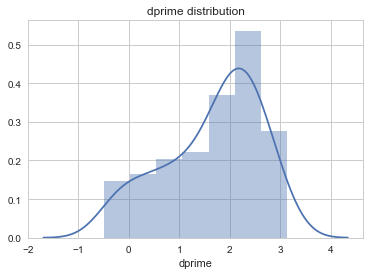

In [26]:
sns.distplot(condM_dprime.dprime)
plt.title('dprime distribution')

#### 3f. Subsequent memory (RT) as a function of  memCond

------Memory RT--------
memCond
old-switch-RIC    914.882253
old-switch-RC     925.498052
old-repeat-RIC    911.048804
old-repeat-RC     914.124020
new               957.596002
Name: sbjRT, dtype: float64


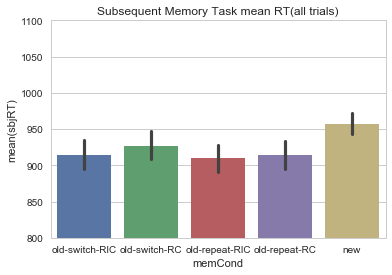

In [27]:
condM_mem_rt = df_mem.groupby(['sbjId','memCond']).sbjRT.mean().reset_index()
# a table of subject x condition 
print('------Memory RT--------')
gpResult_mem_rt = condM_mem_rt.groupby(['memCond']).sbjRT.mean()
print(gpResult_mem_rt)
# plot results
g = sns.barplot(x='memCond',y='sbjRT', data=df_mem)
g.set(ylim=(800, 1100))
plt.title("Subsequent Memory Task mean RT(all trials)")